In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')

In [4]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

In [6]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
df.Age.fillna(df.Age.median(), inplace=True)
df.Cabin.fillna(df.Cabin.mode()[0], inplace=True)
df.Embarked.fillna(df.Embarked.mode()[0], inplace=True)

In [8]:
df.drop_duplicates
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,B96 B98,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,B96 B98,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,B96 B98,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,B96 B98,S
887,1,1,female,19.0,0,0,30.0000,B42,S
888,0,3,female,28.0,1,2,23.4500,B96 B98,S
889,1,1,male,26.0,0,0,30.0000,C148,C


In [9]:

le = LabelEncoder()

for col in ['Sex', 'Embarked', 'Cabin']:
  if df[col].dtype == 'object':
    df[col] = le.fit_transform(df[col].astype(str))

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,47,2
1,1,1,0,38.0,1,0,71.2833,81,0
2,1,3,0,26.0,0,0,7.9250,47,2
3,1,1,0,35.0,1,0,53.1000,55,2
4,0,3,1,35.0,0,0,8.0500,47,2


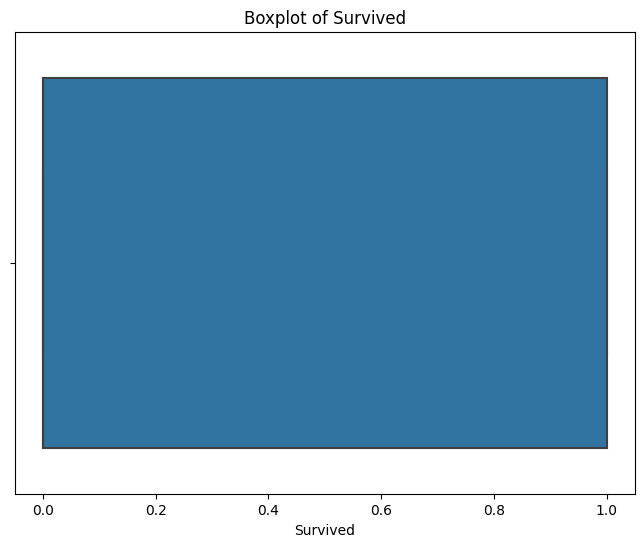

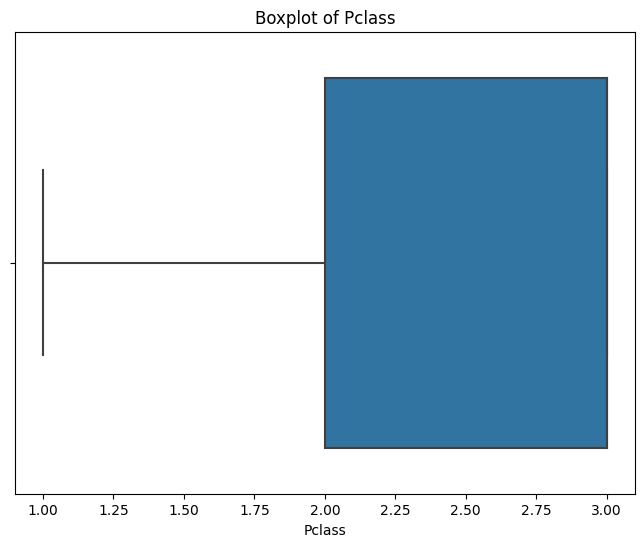

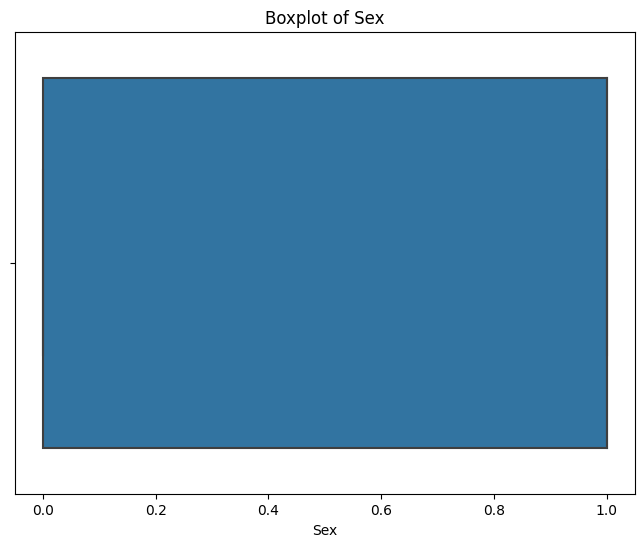

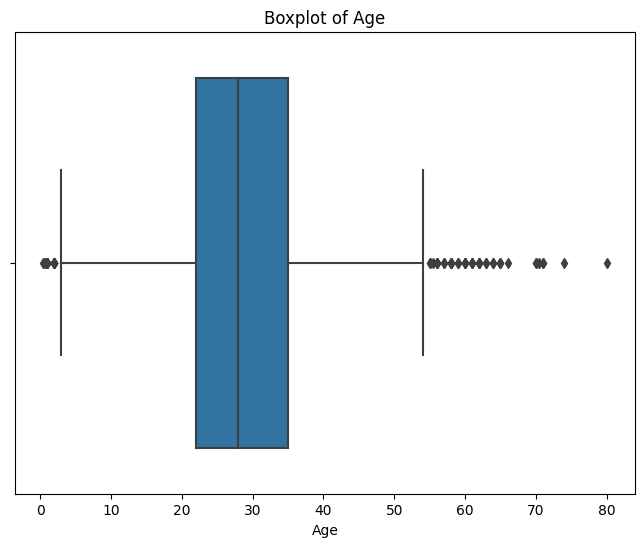

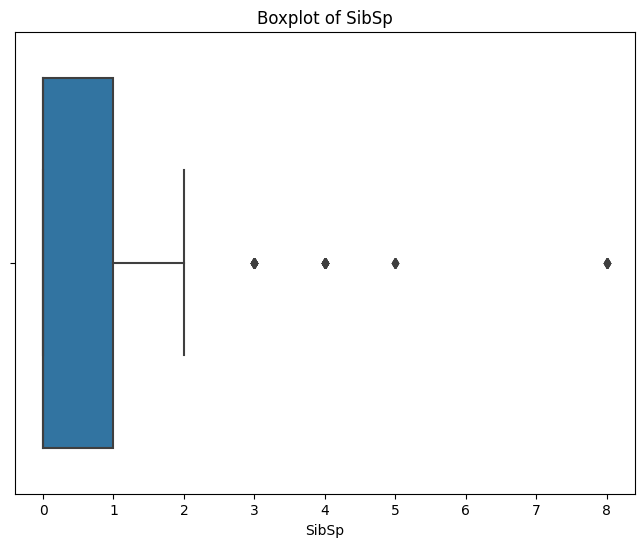

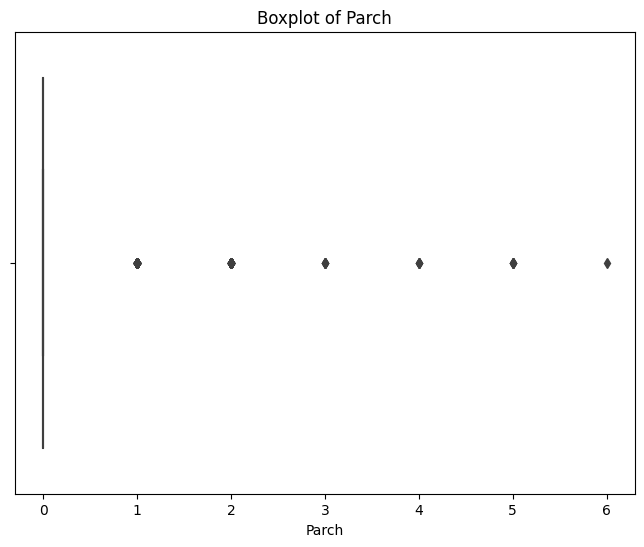

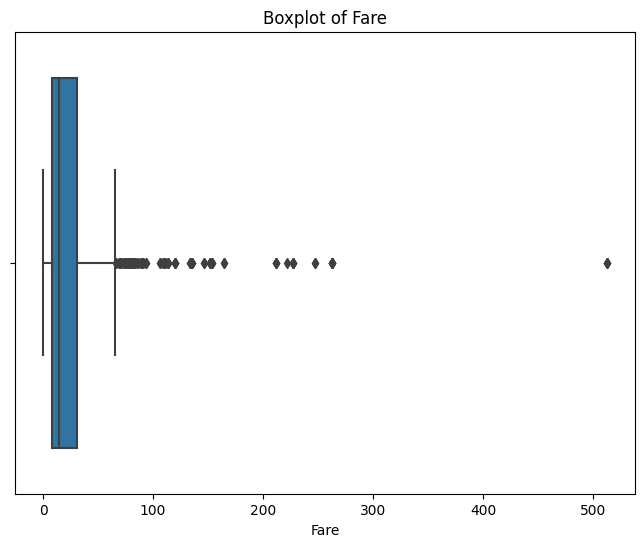

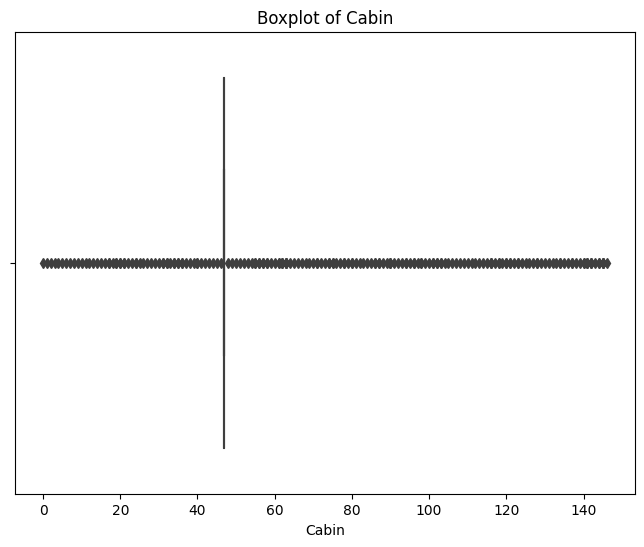

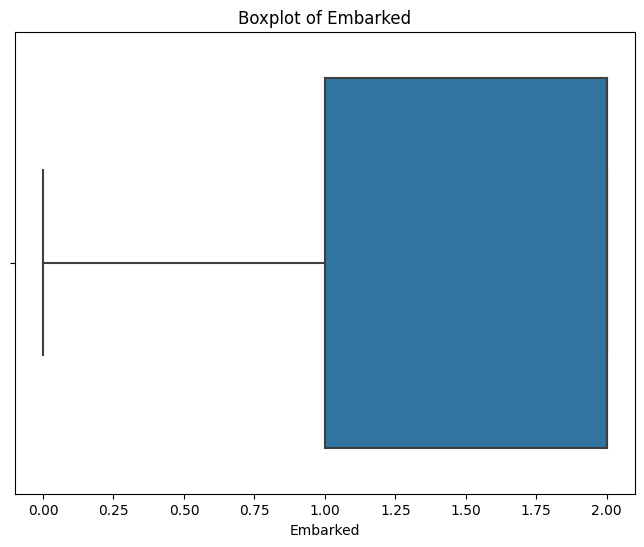

In [10]:
for column in df.columns:
  if pd.api.types.is_numeric_dtype(df[column]):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()


In [11]:
def remove_outliers_iqr(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
  return df_no_outliers

df = remove_outliers_iqr(df, 'Age')
df = df.drop(df[df.SibSp > 5].index)
df = df.drop(df[df.Fare > 255].index)

df.shape


(810, 9)

In [12]:
X = df.drop('Survived', axis=1)
y = df['Survived']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


model = LogisticRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


print(classification_report(y_test, y_pred))


Accuracy: 0.8522167487684729
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       123
           1       0.84      0.78      0.81        80

    accuracy                           0.85       203
   macro avg       0.85      0.84      0.84       203
weighted avg       0.85      0.85      0.85       203

